### Import thư viện

In [1]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import statsmodels.api as sm
import statsmodels.formula.api as smf
from matplotlib import pyplot as plt

### Đọc dữ liệu

In [2]:
data=pd.read_csv('data.csv')
print(data.shape)
data.sample(5)

(7445, 9)


,Date,Price,Open,High,Low,Vol.,Change %,Ticker Symbol,Bank Name
5293,01/20/2021,"34,500.0","34,200.0","34,750.0","32,000.0",25.77M,1.77%,TCB,Techcombank
4951,06/09/2022,"37,400.0","37,250.0","37,550.0","37,050.0",5.78M,0.40%,TCB,Techcombank
5551,01/10/2020,"23,150.0","23,000.0","23,500.0","23,000.0",3.68M,0.43%,TCB,Techcombank
3985,05/08/2020,"15,582.9","15,433.8","16,142.1","15,359.2",16.35M,2.45%,CTG,Vietinbank
2338,12/17/2020,"36,110.9","36,422.2","37,044.8","36,110.9",4.90M,-2.11%,BID,BIDV


### Xử lý dữ liệu

In [3]:
# Chuyển đổi cột 'Date' sang kiểu dữ liệu datetime
data['Date'] = pd.to_datetime(data['Date'])
# Chuyển đổi các cột số sang kiểu dữ liệu số
numeric_columns = ['Price', 'Open', 'High', 'Low', 'Change %']
for col in numeric_columns:
    data[col] = data[col].astype(str).str.replace(',', '').str.replace('%', '')
    data[col] = pd.to_numeric(data[col], errors='coerce')

def convert_volume(vol):
    if vol.endswith('M'):
        return float(vol[:-1]) * 1_000_000
    elif vol.endswith('K'):
        return float(vol[:-1]) * 1_000
    else:
        return float(vol)

if (data['Vol.'].dtype == 'O'):
    data['Vol.'] = data['Vol.'].apply(convert_volume)

# Sắp xếp dữ liệu theo cột 'Date' tăng dần
data = data.sort_values(by='Date')

# Kiểm tra loại dữ liệu của các cột
print(data.dtypes)

data.tail(5)

Date             datetime64[ns]
Price                   float64
Open                    float64
High                    float64
Low                     float64
Vol.                    float64
Change %                float64
Ticker Symbol            object
Bank Name                object
dtype: object


,Date,Price,Open,High,Low,Vol.,Change %,Ticker Symbol,Bank Name
1489,2024-05-20,49600.0,49450.0,50700.0,49400.0,2190000.0,0.51,BID,BIDV
5956,2024-05-20,20150.0,20100.0,20600.0,20100.0,1410000.0,0.25,AGR,Agribank
2978,2024-05-20,33350.0,33150.0,33900.0,33100.0,12150000.0,0.76,CTG,Vietinbank
4467,2024-05-20,49840.0,49750.0,50400.0,46750.0,9300000.0,0.18,TCB,Techcombank
0,2024-05-20,91900.0,92000.0,98200.0,88700.0,1040000.0,0.11,VCB,Vietcombank


### Câu hỏi: Có sự tương quan (có ý nghĩa về thống kê) giữa giá cổ phiếu và khối lượng giao dịch đối với từng ngân hàng; trong tổng thể hay không?

In [4]:
# Hàm tạo biểu đồ đường cho giá cổ phiếu
def create_line_chart(data, visible=False):
    return go.Scatter(
        x=data['Date'],
        y=data['Price'],
        mode='lines',
        visible=visible,
        name='Giá cổ phiếu',
        line=dict(color='blue')
    )

# Hàm tạo biểu đồ khối lượng giao dịch
def create_volume_chart(data, visible=False):
    colors = ['red' if row['Price'] <= row['Open'] else 'green' for _, row in data.iterrows()]
    return go.Bar(
        x=data['Date'],
        y=data['Vol.'],
        marker=dict(color=colors, opacity=1.0),
        visible=visible,
        name='Khối lượng giao dịch',
        yaxis='y2'  # Use a second y-axis
    )

# Lấy danh sách các cổ phiếu
unique_tickers = data['Ticker Symbol'].unique()
print(unique_tickers)

# Tạo biểu đồ
fig = go.Figure()

# Lấy dữ liệu theo từng cổ phiếu
data_grouped = [data[data['Ticker Symbol'] == ticker] for ticker in unique_tickers]

# Thêm traces cho cổ phiếu
for i in range(len(data_grouped)):
    fig.add_trace(create_line_chart(data_grouped[i], visible=i == 0))
    fig.add_trace(create_volume_chart(data_grouped[i], visible=i == 0))

# Cập nhật layout với updatemenus
fig.update_layout(
    title=f'Khối lượng giao dịch và giá cổ phiếu {unique_tickers[0]}',
    xaxis_title='Ngày',
    yaxis=dict(
        title='Giá cổ phiếu',
        titlefont=dict(size=14, color='black')
    ),
    yaxis2=dict(
        title='Khối lượng giao dịch',
        overlaying='y',
        side='right'
    ),
    updatemenus=[
        {
            'buttons': [
                {
                    'label': ticker,
                    'method': 'update',
                    'args': [
                        {'visible': [ticker == t for t in unique_tickers for _ in range(2)]},
                        {'title': f'Khối lượng giao dịch và giá cổ phiếu - {ticker}'},
                        {'showlegend': True},
                    ]
                }
                for ticker in unique_tickers
            ]
        }
    ]
)

# Hiển thị biểu đồ
fig.show()

['AGR' 'BID' 'CTG' 'VCB' 'TCB']


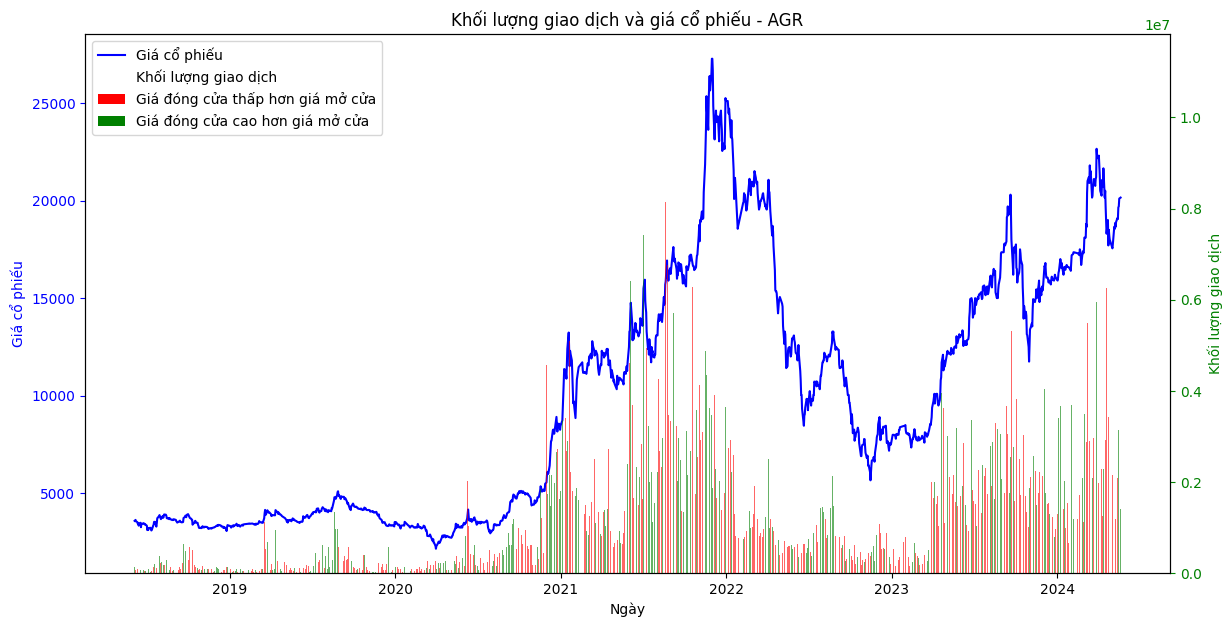

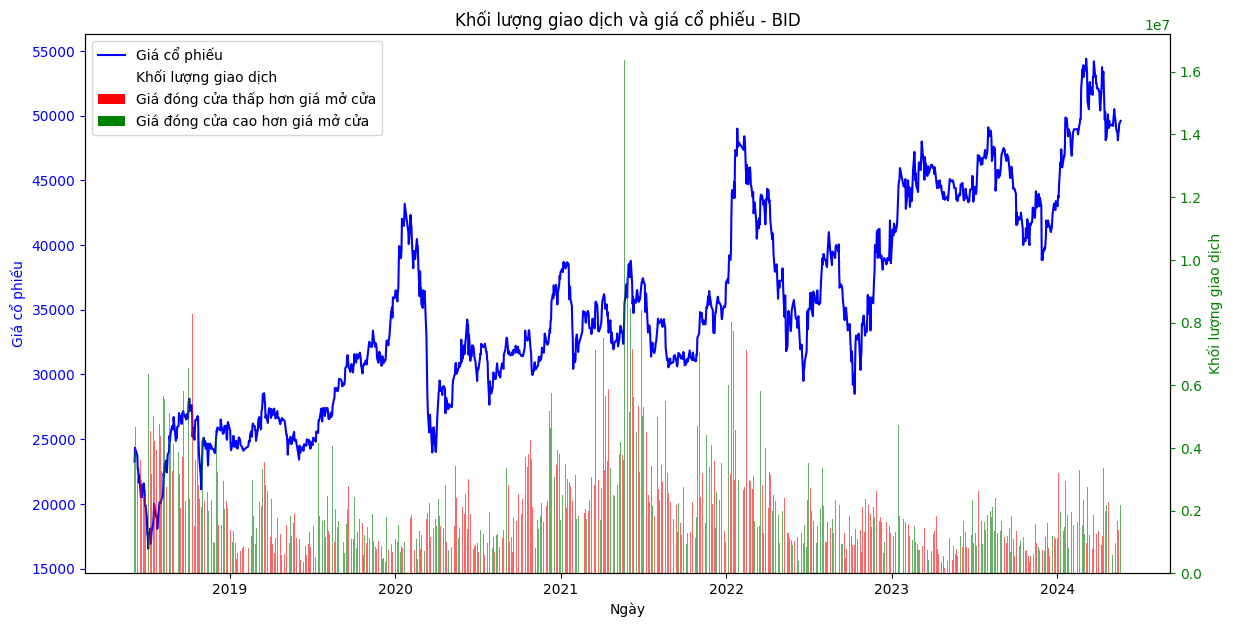

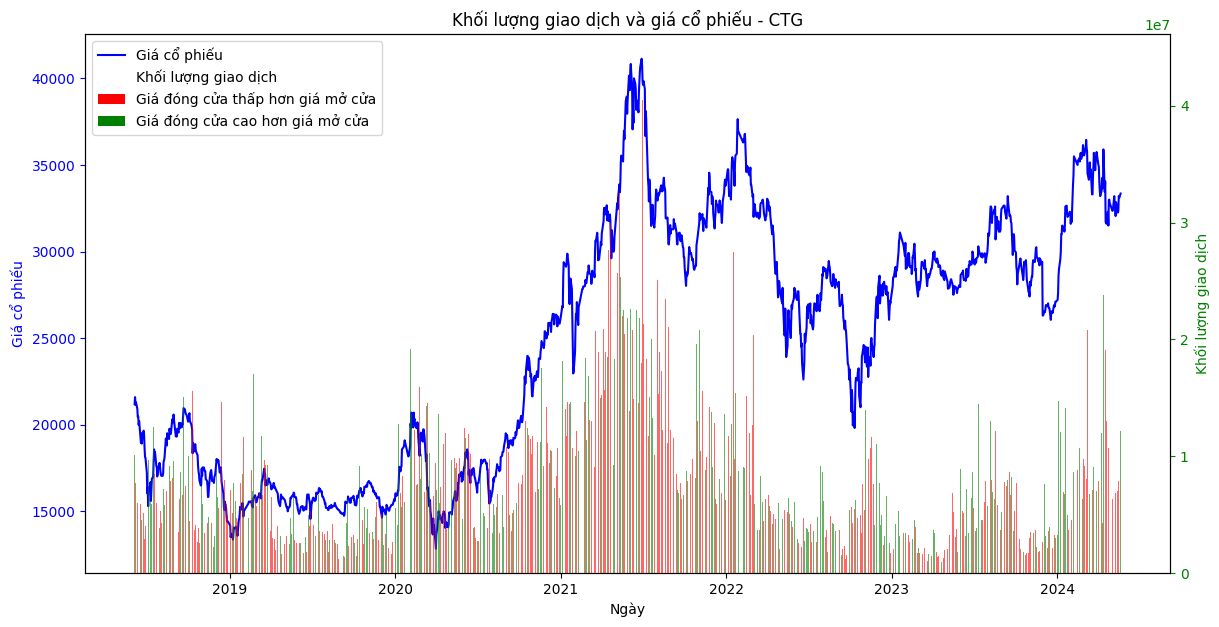

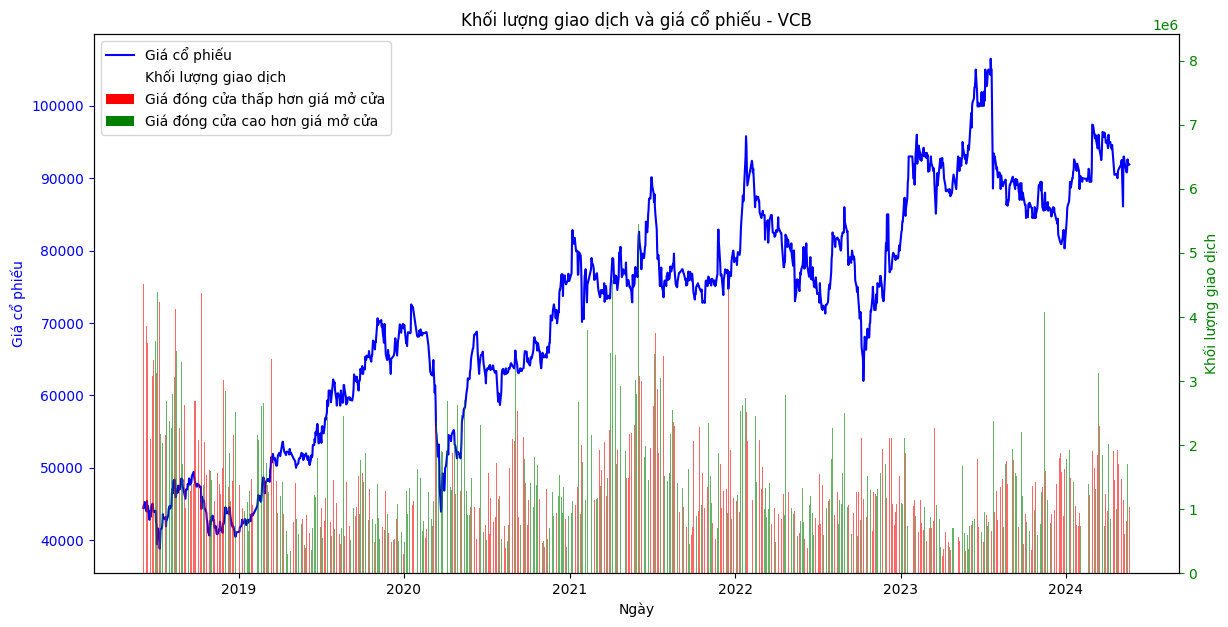

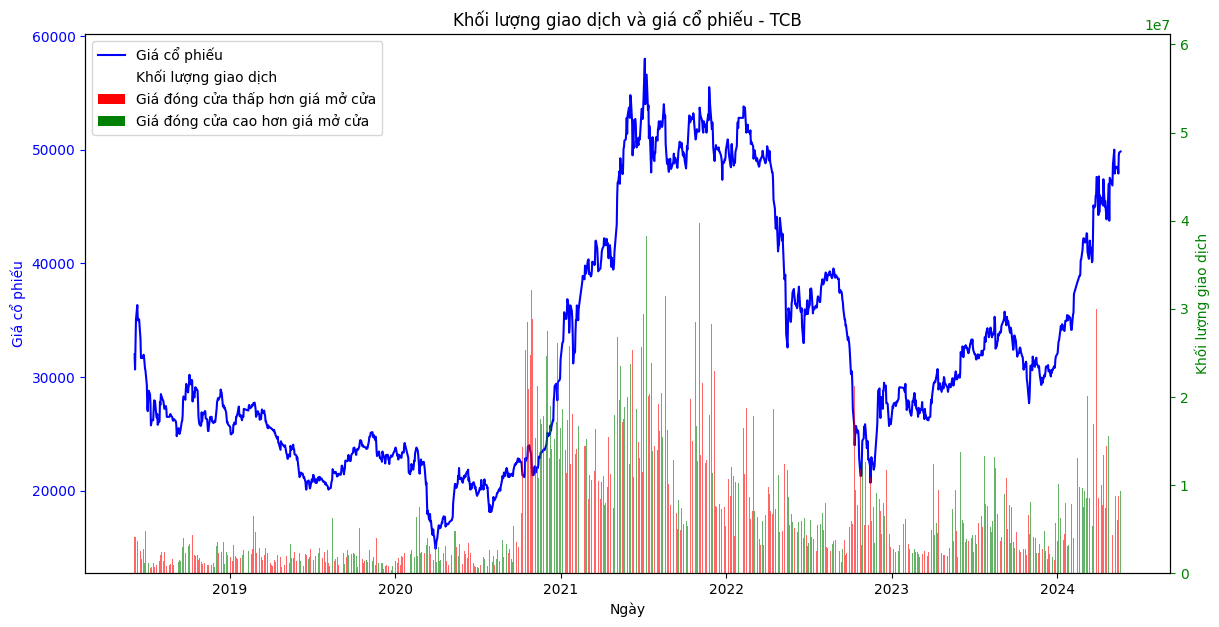

In [5]:
# List of unique tickers
unique_tickers = data['Ticker Symbol'].unique()

# Function to create the combined plot
def create_combined_chart(ticker_data, ticker):
    fig, ax1 = plt.subplots(figsize=(14, 7))

    # Plot the stock price as a line chart
    ax1.plot(ticker_data['Date'], ticker_data['Price'], 'b-', label='Giá cổ phiếu')
    ax1.set_xlabel('Ngày')
    ax1.set_ylabel('Giá cổ phiếu', color='b')
    ax1.tick_params('y', colors='b')

    # Create a second y-axis for the trading volume
    ax2 = ax1.twinx()
    colors = ['red' if row['Price'] <= row['Open'] else 'green' for _, row in ticker_data.iterrows()]
    ax2.bar(ticker_data['Date'], ticker_data['Vol.'], color=colors, alpha=0.6, label='Khối lượng giao dịch')
    ax2.set_ylabel('Khối lượng giao dịch', color='g')
    ax2.tick_params('y', colors='g')

    # Add a title and legends
    plt.title(f'Khối lượng giao dịch và giá cổ phiếu - {ticker}')

    # Custom legend for volume color
    price_patch = plt.Line2D([], [], color='blue', label='Giá cổ phiếu')
    volume_patch= plt.Rectangle((0, 0), 1, 1, fc="none", edgecolor='none', label='Khối lượng giao dịch')
    red_patch = plt.Rectangle((0, 0), 1, 1, fc="red", edgecolor='none', label='Giá đóng cửa thấp hơn giá mở cửa')
    green_patch = plt.Rectangle((0, 0), 1, 1, fc="green", edgecolor='none', label='Giá đóng cửa cao hơn giá mở cửa')
    
    ax1.legend(handles=[price_patch, volume_patch, red_patch, green_patch], loc='upper left')

    plt.show()

# Plot for each ticker symbol
for ticker in unique_tickers:
    ticker_data = data[data['Ticker Symbol'] == ticker]
    create_combined_chart(ticker_data, ticker)

#### **Nhận xét**:
**Nhận xét chung:**
- Mối quan hệ tương quan giữa giá cổ phiếu và khối lượng giao dịch nhìn chung là tích cực. Khi giá cổ phiếu tăng, khối lượng giao dịch cũng có xu hướng tăng theo, và ngược lại. Điều này cho thấy rằng nhà đầu tư có xu hướng mua nhiều cổ phiếu hơn khi họ tin tưởng rằng giá cổ phiếu sẽ tăng, và bán nhiều cổ phiếu hơn khi họ tin tưởng rằng giá cổ phiếu sẽ giảm.
- Mức độ tương quan giữa giá cổ phiếu và khối lượng giao dịch có thể khác nhau tùy thuộc vào từng cổ phiếu. Một số cổ phiếu có mức độ tương quan cao hơn, trong khi một số cổ phiếu có mức độ tương quan thấp hơn.

**Nhận xét riêng từng loại cổ phiếu:**
1. AGR (Agribank): Mối quan hệ tương quan giữa giá cổ phiếu và khối lượng giao dịch của AGR là tương đối cao. Khi giá cổ phiếu AGR tăng, khối lượng giao dịch cũng có xu hướng tăng theo, và ngược lại.
2. BID (BIDV): Mối quan hệ tương quan giữa giá cổ phiếu và khối lượng giao dịch của BID là tương đối thấp.
3. CTG (Vietinbank): Mối quan hệ tương quan giữa giá cổ phiếu và khối lượng giao dịch của CTG là tương đối cao.
4. VCB (Vietcombank): Mối quan hệ tương quan giữa giá cổ phiếu và khối lượng giao dịch của VCB là tương đối thấp.
5. TCB (Techcombank): Mối quan hệ tương quan giữa giá cổ phiếu và khối lượng giao dịch của TCB là tương đối cao.

**Kết luận:**
- Mối quan hệ tương quan giữa giá cổ phiếu và khối lượng giao dịch nhìn chung là tích cực, nhưng mức độ tương quan có thể khác nhau tùy thuộc vào từng cổ phiếu.
- Có một số yếu tố khác có thể ảnh hưởng đến khối lượng giao dịch, ngoài giá cổ phiếu.

#### Kiểm định thống kê
Thực hiện kiểm định mô hình hồi quy tuyến tính OLS

In [6]:
# Thực hiện hồi quy tuyến tính cho từng ngân hàng
results = {}
for ticker in data['Ticker Symbol'].unique():
    data_subset = data[data['Ticker Symbol'] == ticker]  
    if data_subset.empty:
        continue 
    model = smf.ols('Price ~ Q("Vol.")', data=data_subset).fit()
    results[ticker] = model.summary()

# In kết quả hồi quy cho từng ngân hàng
for ticker, summary in results.items():
    print(f'Results for {ticker}:')
    print(summary)
    print('\n')

Results for AGR:
                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.420
Model:                            OLS   Adj. R-squared:                  0.420
Method:                 Least Squares   F-statistic:                     1078.
Date:                Sun, 26 May 2024   Prob (F-statistic):          3.26e-178
Time:                        17:56:27   Log-Likelihood:                -14715.
No. Observations:                1489   AIC:                         2.943e+04
Df Residuals:                    1487   BIC:                         2.944e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   6189.1323    163.314   

#### Nhận xét:
1. **AGR (Agribank):**
- Giá trị `R-squared` và `Adj. R-squared` là 0.420, nghĩa là mô hình hồi quy giải thích được 42% biến động của giá cổ phiếu (Price) dựa trên khối lượng giao dịch (Vol.). Đây là một tỷ lệ giải thích khá, nhưng vẫn còn 58% biến động không được giải thích bởi mô hình này.
- Giá trị `F-statistic` là 1077 với mức ý nghĩa (`Prob`) rất nhỏ (3.84e-178), cho thấy mô hình có ý nghĩa thống kê, tức là khối lượng giao dịch có ảnh hưởng đáng kể đến giá cổ phiếu.
- Giá trị `p (P>|t|)`: Cả hai hệ số đều có giá trị p rất nhỏ (0.000), cho thấy chúng đều có ý nghĩa thống kê cao.
- Hệ số chặn (`Intercept`) là 6182.4255. Đây là giá trị trung bình của giá cổ phiếu khi khối lượng giao dịch bằng 0.
- Hệ số của khối lượng giao dịch là 0.0030. Điều này có nghĩa là khi khối lượng giao dịch tăng lên 1 đơn vị (sau khi chuyển đổi), giá cổ phiếu tăng trung bình 0.0030 đơn vị.
- Phương trình hồi quy: `Price=6182.4255 + 0.0030 * Vol.`
- **Kết luận**: Khối lượng giao dịch có ảnh hưởng đáng kể đến giá cổ phiếu của AGR. Hệ số dương cho thấy khi khối lượng giao dịch tăng, giá cổ phiếu cũng có xu hướng tăng.
2. **BID (BIDV):**
- Giá trị `R-squared` và `Adj. R-squared` là 0.022, nghĩa là mô hình hồi quy chỉ giải thích được 2.2% biến động của giá cổ phiếu (Price) dựa trên khối lượng giao dịch (Vol.). Đây là tỷ lệ giải thích rất thấp, cho thấy mô hình này không phải là một mô hình tốt để dự đoán giá cổ phiếu dựa trên khối lượng giao dịch cho BIDV.
- Giá trị `F-statistic` là 32.88 với mức ý nghĩa (`Prob`) rất nhỏ (1.18e-08), cho thấy mô hình có ý nghĩa thống kê, tức là khối lượng giao dịch có ảnh hưởng đáng kể đến giá cổ phiếu.
- Giá trị `p (P>|t|)`: Cả hai hệ số đều có giá trị p rất nhỏ (0.000), cho thấy chúng đều có ý nghĩa thống kê cao.
- Hệ số chặn (`Intercept`) là 36610. Đây là giá trị trung bình của giá cổ phiếu khi khối lượng giao dịch bằng 0.
- Hệ số của khối lượng giao dịch là -0.0008. Điều này có nghĩa là khi khối lượng giao dịch tăng lên 1 đơn vị (sau khi chuyển đổi), giá cổ phiếu giảm trung bình 0.0008 đơn vị.
- Phương trình hồi quy: `Price = 36610 - 0.0008 * Vol.`
- **Kết luận**: dù khối lượng giao dịch có ảnh hưởng đến giá cổ phiếu của BIDV nhưng mức độ giải thích của mô hình là rất thấp, và ảnh hưởng của khối lượng giao dịch là ngược chiều với giá cổ phiếu.
3. **CTG (VietinBank):**
- Giá trị `R-squared` và `Adj. R-squared` là 0.150, nghĩa là mô hình hồi quy giải thích được 15% biến động của giá cổ phiếu (Price) dựa trên khối lượng giao dịch (Vol.). Đây là một tỷ lệ giải thích trung bình, cho thấy mô hình này có thể dự đoán một phần giá cổ phiếu dựa trên khối lượng giao dịch.
- Giá trị `F-statistic` là 262.5 với mức ý nghĩa (`Prob`) rất nhỏ (1.72e-54), cho thấy mô hình có ý nghĩa thống kê, tức là khối lượng giao dịch có ảnh hưởng đáng kể đến giá cổ phiếu.
- Giá trị `p (P>|t|)`: Cả hai hệ số đều có giá trị p rất nhỏ (0.000), cho thấy chúng đều có ý nghĩa thống kê cao.
- Hệ số chặn (`Intercept`) là 20980. Đây là giá trị trung bình của giá cổ phiếu khi khối lượng giao dịch bằng 0.
- Hệ số của khối lượng giao dịch là 0.0005. Điều này có nghĩa là khi khối lượng giao dịch tăng lên 1 đơn vị (sau khi chuyển đổi), giá cổ phiếu tăng trung bình 0.0005 đơn vị.
- Phương trình hồi quy: `Price = 20980 + 0.0005 * Vol.`
- **Kết luận**: khối lượng giao dịch có ảnh hưởng đáng kể đến giá cổ phiếu của VietinBank, và mô hình hồi quy này có thể giải thích được 15% biến động của giá cổ phiếu dựa trên khối lượng giao dịch. Điều này cho thấy có một mức độ tương quan nhất định giữa hai biến này, nhưng vẫn còn 85% biến động không được giải thích bởi mô hình.
4. **VCB (Vietcombank):**
- Giá trị `R-squared` và `Adj. R-squared` là 0.042, nghĩa là mô hình hồi quy giải thích được 4.2% biến động của giá cổ phiếu (Price) dựa trên khối lượng giao dịch (Vol.). Đây là một tỷ lệ giải thích rất thấp, cho thấy mô hình này không thể dự đoán tốt giá cổ phiếu dựa trên khối lượng giao dịch.
- Giá trị `F-statistic` là 65.42 với mức ý nghĩa (`Prob`) rất nhỏ (1.24e-15), cho thấy mô hình có ý nghĩa thống kê, tức là khối lượng giao dịch có ảnh hưởng đáng kể đến giá cổ phiếu, mặc dù mức độ ảnh hưởng là rất nhỏ.
- Giá trị `p (P>|t|)`: Cả hai hệ số đều có giá trị p rất nhỏ (0.000), cho thấy chúng đều có ý nghĩa thống kê cao.
- Hệ số chặn (`Intercept`) là 77090. Đây là giá trị trung bình của giá cổ phiếu khi khối lượng giao dịch bằng 0.
- Hệ số của khối lượng giao dịch là -0.0039. Điều này có nghĩa là khi khối lượng giao dịch tăng lên 1 đơn vị (sau khi chuyển đổi), giá cổ phiếu giảm trung bình 0.0039 đơn vị.
- Phương trình hồi quy: `Price = 77090 - 0.0039 * Vol.`
- **Kết luận**: mặc dù khối lượng giao dịch có ý nghĩa thống kê trong việc ảnh hưởng đến giá cổ phiếu của Vietcombank, tỷ lệ giải thích của mô hình rất thấp (chỉ 4.2%). Điều này cho thấy có nhiều yếu tố khác ảnh hưởng đến giá cổ phiếu hơn là chỉ khối lượng giao dịch.
5. **TCB (Techcombank):**
- **Giá trị `R-squared` và `Adj. R-squared`**: 0.275, nghĩa là mô hình hồi quy giải thích được 27.5% biến động của giá cổ phiếu (Price) dựa trên khối lượng giao dịch (Vol.). Đây là tỷ lệ giải thích trung bình, cho thấy khối lượng giao dịch có một mức độ ảnh hưởng đáng kể đến giá cổ phiếu nhưng vẫn còn nhiều yếu tố khác cần được xem xét.
- **Giá trị `F-statistic`**: 562.8 với mức ý nghĩa (`Prob`) rất nhỏ (9.37e-106), cho thấy mô hình có ý nghĩa thống kê cao. Điều này nghĩa là khối lượng giao dịch có ảnh hưởng đáng kể đến giá cổ phiếu.
- **Giá trị `p (P>|t|)`**: Cả hai hệ số đều có giá trị p rất nhỏ (0.000), cho thấy chúng đều có ý nghĩa thống kê cao.
- **Hệ số chặn (`Intercept`)**: 27010. Đây là giá trị trung bình của giá cổ phiếu khi khối lượng giao dịch bằng 0.
- **Hệ số của khối lượng giao dịch**: 0.0008. Điều này có nghĩa là khi khối lượng giao dịch tăng lên 1 đơn vị (sau khi chuyển đổi), giá cổ phiếu tăng trung bình 0.0008 đơn vị.
- **Phương trình hồi quy**: `Price = 27010 + 0.0008 * Vol.`
- **Kết luận**: kết quả hồi quy cho thấy có một mối quan hệ tích cực giữa khối lượng giao dịch và giá cổ phiếu của Techcombank. Khối lượng giao dịch có thể giải thích được 27.5% biến động của giá cổ phiếu, và điều này có ý nghĩa thống kê cao. Tuy nhiên, vẫn còn 72.5% biến động của giá cổ phiếu được giải thích bởi các yếu tố khác không được bao gồm trong mô hình này.

### Câu hỏi: So sánh và nhận xét về giá cổ phiếu và khối lượng giao dịch theo thời gian giữa các ngân hàng. Nên chọn đầu tư cổ phiếu nào?

#### Biến động giá cổ phiếu theo thời gian

In [7]:
# Biểu đồ giá cổ phiếu theo thời gian
fig = px.line(data, x='Date', y='Price', color='Ticker Symbol', title='Biểu đồ giá cổ phiếu theo thời gian')
fig.show()

#### **Nhận xét:**
Giá cổ phiếu của 5 ngân hàng nhìn chung đều có xu hướng tăng, nhưng còn nhiều biến động.

VCB (Vietcombank) có giá cổ phiếu cao hơn hẳn 4 cổ phiếu còn lại

AGR (Agribank) có giá cổ phiếu thấp hơn hẳn 4 cổ phiếu còn lại

Có những điểm tương đồng trong quá trình biến thiên của giá cổ phiếu giữa 5 ngân hàng:
1. Cùng giảm mạnh vào tháng 7/2018:
- Áp lực lạm phát và tăng lãi suất: Mặc dù chỉ số giá tiêu dùng giảm nhẹ, sức ép lạm phát dự báo sẽ tăng do giá dầu thô và tỷ giá tăng. Ngân hàng Nhà nước (NHNN) đã phải áp dụng các biện pháp kiểm soát lạm phát và thắt chặt tín dụng, dẫn đến tăng lãi suất trên thị trường liên ngân hàng .

- Chính sách tiền tệ thận trọng: NHNN tiếp tục điều hành chính sách tiền tệ một cách thận trọng, tăng cường phát hành tín phiếu để hút bớt tiền đồng ra khỏi lưu thông, nhằm kiểm soát lượng tiền cung ứng và ổn định tỷ giá .

- Tăng lãi suất huy động: Các ngân hàng bắt đầu tăng lãi suất huy động để thu hút vốn, tăng chi phí vốn và làm giảm lợi nhuận tiềm năng .

- Biến động tỷ giá và thị trường thế giới: Sự bất định trên thị trường quốc tế, như việc Fed tăng lãi suất và chiến tranh thương mại Mỹ-Trung, cũng tạo áp lực lên tỷ giá và lạm phát trong nước, buộc NHNN phải thận trọng hơn trong điều hành chính sách .

- Lo ngại về pha loãng cổ phiếu: Việc các ngân hàng tăng vốn nhanh chóng gây lo ngại về pha loãng cổ phiếu, khiến tốc độ tăng trưởng thu nhập trên mỗi cổ phiếu (EPS) chậm lại, làm giảm hấp dẫn của cổ phiếu ngân hàng .

- Tâm lý thị trường tiêu cực: Mặc dù hoạt động của ngành ngân hàng và kết quả kinh doanh 6 tháng đầu năm 2018 rất khả quan, giá cổ phiếu ngân hàng giảm mạnh do tâm lý thị trường tiêu cực và việc VN-Index mất điểm đáng kể trong quý II/2018 .


**Nguồn:** https://baodautu.vn/co-phieu-vua-ha-nhiet-ngan-hang-chun-buoc-len-san-d85620.html, https://sbv.gov.vn/webcenter/portal/vi/menu/trangchu/ttsk/ttsk_chitiet;jsessionid=lhuozW-5L97onjbpbSC-IajtAbAKd1TQIxh46Gxiz8wX4xcwZvtg!715280987!-1398135400?dDocName=SBV348576&p=3&_afrLoop=52514788789773466#%40%3F_afrLoop%3D52514788789773466%26centerWidth%3D80%2525%26dDocName%3DSBV348576%26leftWidth%3D20%2525%26p%3D3%26rightWidth%3D0%2525%26showFooter%3Dfalse%26showHeader%3Dfalse%26_adf.ctrl-state%3D1bg3ru66kj_4 

2. Cùng tăng mạnh vào tháng 2/2020:
- Hiệu suất tăng trưởng mạnh: Trong hai tháng đầu năm 2020, cổ phiếu ngân hàng đã tăng giá 30,19%, đứng thứ ba trong các nhóm ngành có biên độ tăng cao. 

- Giá cổ phiếu hấp dẫn: Chỉ số P/E của ngành ngân hàng ở mức trung bình 16,87 lần, còn các ngân hàng lớn và trung bình chỉ khoảng 8,89 lần, thấp hơn so với năm 2018. Điều này tạo sự hấp dẫn đối với các nhà đầu tư.

- Kết quả kinh doanh tích cực: Lợi nhuận của các ngân hàng trong năm 2019 tăng trung bình 42%, cao hơn so với nhiều ngành khác, với một số ngân hàng lớn và trung bình có mức tăng trưởng vượt trội.

- Tác động của bộ chỉ số mới: Sự ra đời của bộ chỉ số VN-Diamond và VNFin Select, trong đó có nhiều cổ phiếu ngân hàng, đã thu hút dòng tiền đầu tư vào nhóm ngành này.

- Hiệp định EVFTA: Hiệp định EVFTA cho phép các nhà đầu tư từ EU sở hữu đến 49% tại hai ngân hàng thương mại, nâng tỷ lệ sở hữu ngoại lên so với quy định hiện hành là 30%, tạo kỳ vọng tăng giá cổ phiếu.

- Tăng trưởng thu nhập ngoài lãi: Thu nhập từ dịch vụ và các khoản thu ngoài lãi như phí dịch vụ, thu hồi nợ xấu, và bán chéo sản phẩm bảo hiểm dự kiến tăng trưởng từ 20-30% trong năm 2020.

- Hoạt động M&A sôi động: Các thương vụ mua bán và sáp nhập, như việc KEB Hana Bank đầu tư vào BIDV và GIC cùng Mizuho đầu tư vào Vietcombank, tạo triển vọng tích cực cho ngành ngân hàng.

**Nguồn:**: https://www.sbv.gov.vn/webcenter/portal/vi/menu/trangchu/ttsk/ttsk_chitiet?leftWidth=20%25&showFooter=false&showHeader=false&dDocName=SBV406270&rightWidth=0%25&centerWidth=80%25&_afrLoop=52516756681433023#%40%3F_afrLoop%3D52516756681433023%26centerWidth%3D80%2525%26dDocName%3DSBV406270%26leftWidth%3D20%2525%26rightWidth%3D0%2525%26showFooter%3Dfalse%26showHeader%3Dfalse%26_adf.ctrl-state%3De3dqubedy_9

3. Cùng giảm mạnh vào tháng 3/2020:
- Dịch Covid-19: Đại dịch Covid-19 bùng phát mạnh mẽ trên toàn cầu, gây ra lo ngại về sức khỏe cộng đồng và tác động tiêu cực đến hoạt động kinh tế. Các biện pháp giãn cách xã hội và phong tỏa khiến nhiều doanh nghiệp ngừng hoạt động, ảnh hưởng xấu đến nền kinh tế nói chung và ngành ngân hàng nói riêng.

- Thị trường chứng khoán toàn cầu giảm mạnh: Thị trường chứng khoán trên khắp thế giới, bao gồm Mỹ, châu Âu và châu Á, đều đồng loạt giảm điểm. Điều này tác động tiêu cực đến tâm lý nhà đầu tư tại Việt Nam, khiến họ bán tháo cổ phiếu để giảm thiểu rủi ro.

- Chính sách tiền tệ nới lỏng: Nhiều ngân hàng trung ương trên thế giới, bao gồm cả Ngân hàng Nhà nước Việt Nam, đã thực hiện các biện pháp nới lỏng tiền tệ như giảm lãi suất để hỗ trợ nền kinh tế. Dù đây là biện pháp nhằm kích thích kinh tế, nhưng nó cũng làm giảm lợi nhuận kỳ vọng của các ngân hàng, do lãi suất cho vay và lợi nhuận từ hoạt động tín dụng giảm.

- Giảm nhu cầu tín dụng: Hoạt động sản xuất kinh doanh đình trệ khiến nhu cầu tín dụng giảm sút mạnh. Tăng trưởng tín dụng trong những tháng đầu năm 2020 đạt mức thấp nhất trong nhiều năm, chỉ 0.06% trong hai tháng đầu năm, cho thấy sự suy giảm nghiêm trọng trong hoạt động vay mượn.

- Gánh nặng nợ xấu tăng: Nhiều doanh nghiệp gặp khó khăn trong việc trả nợ do ảnh hưởng của dịch bệnh, làm tăng nguy cơ nợ xấu. Ngân hàng phải cơ cấu lại thời hạn trả nợ, miễn, giảm lãi và phí, giữ nguyên nhóm nợ nhằm hỗ trợ khách hàng, từ đó làm giảm lợi nhuận của ngành ngân hàng.

- Khối ngoại bán ròng: Khối ngoại đã bán ròng mạnh trên thị trường chứng khoán Việt Nam, đặc biệt là cổ phiếu ngân hàng. Việc bán ròng này gia tăng áp lực giảm giá cổ phiếu, do tâm lý lo ngại kinh tế suy thoái và dòng vốn ngoại rút khỏi các thị trường mới nổi.

**Nguồn:** https://tapchitaichinh.vn/so-lieu-thi-truong-chung-khoan-thang-3-2020.html, https://cafef.vn/chung-khoan-viet-nam-giam-31-trong-quy-1-thiet-lap-hang-loat-ky-luc-buon-cho-nha-dau-tu-20200331165612893.chn, https://vietstock.vn/2020/03/ssi-research-8216nhnn-se-giam-lai-suat-dieu-hanh-trong-thang-38217-757-737813.htm

4. Cùng tăng mạnh vào tháng 6/2021:
- Triển vọng kinh tế tươi sáng sau đại dịch: Sau đại dịch COVID-19, triển vọng kinh tế Việt Nam được cải thiện, tạo điều kiện thuận lợi cho sự phát triển của ngành ngân hàng. Kinh tế phục hồi giúp các ngân hàng tăng trưởng tín dụng và thu nhập.

- Môi trường lãi suất thấp: Lãi suất thấp thu hút dòng vốn từ các nhà đầu tư cá nhân trong nước vào thị trường chứng khoán, đặc biệt là vào cổ phiếu ngân hàng.

- Thanh khoản cao: Thanh khoản trên thị trường chứng khoán Việt Nam đạt kỷ lục, trung bình 1 tỷ USD/phiên. Ngành ngân hàng ghi nhận thanh khoản cao nhất, chiếm 28,3% tổng giá trị giao dịch toàn thị trường.

- Sự quan tâm của khối ngoại: Khối ngoại mạnh tay mua gom cổ phiếu ngân hàng, thể hiện niềm tin vào tiềm năng tăng trưởng của ngành này. Các quỹ đầu tư quốc tế duy trì tỷ trọng lớn cổ phiếu ngân hàng trong danh mục đầu tư của mình.

- Kết quả kinh doanh tích cực: Nhiều ngân hàng công bố lợi nhuận quý II/2021 tăng trưởng mạnh mẽ, gấp đôi, gấp ba so với cùng kỳ năm trước. Sự phục hồi của tín dụng và duy trì lãi suất huy động ở mức thấp đã đóng góp vào kết quả này.

- Lợi thế về vốn rẻ và tệp khách hàng phong phú: Các ngân hàng như Vietcombank, VietinBank, MB, ACB, Techcombank có lợi thế về vốn rẻ và tệp khách hàng bán lẻ phong phú, giúp họ đạt được kết quả kinh doanh tốt hơn trong cuộc đua lợi nhuận.

- Dự báo triển vọng tích cực: Dự báo tín dụng có khả năng tăng 13-14% trong năm 2021, cao hơn kế hoạch của Ngân hàng Nhà nước. Điều này giúp các ngân hàng có kỳ vọng tăng trưởng lợi nhuận cao.

**Nguồn:** https://tienphong.vn/sieu-co-phieu-6-thang-dau-nam-ngan-hang-va-thep-so-ke-ngoi-dau-bang-post1352367.tpo, https://baodautu.vn/khoi-ngoai-manh-tay-gom-co-phieu-ngan-hang-d146962.html


5. Cùng tăng mạnh vào tháng 1/2022:
- Kết quả kinh doanh tích cực: Các ngân hàng như BIDV (BID), Ngân hàng Quân đội (MBB), Vietcombank (VCB), Sacombank (STB) và Eximbank (EIB) đều báo cáo kết quả kinh doanh quý IV/2021 và cả năm 2021 ấn tượng. BIDV có lợi nhuận trước thuế quý IV tăng 46% so với cùng kỳ năm trước, đạt 2.868 tỷ đồng, và lợi nhuận cả năm tăng 51%, đạt 13.602 tỷ đồng. Ngân hàng Quân đội báo cáo lợi nhuận trước thuế quý IV tăng 82%, đạt 4.643 tỷ đồng, và lợi nhuận cả năm tăng 55%, đạt hơn 16.527 tỷ đồng .

- Tiết giảm chi phí và quản lý rủi ro: BIDV đạt mức tăng trưởng lợi nhuận nhờ tiết giảm hơn 1.100 tỷ đồng chi phí hoạt động và dự phòng rủi ro tín dụng .

- Thanh khoản thị trường: Dù thanh khoản chung của thị trường chứng khoán giảm do kỳ nghỉ Tết, nhưng nhóm cổ phiếu ngân hàng vẫn thu hút được sự chú ý và dòng tiền từ các nhà đầu tư, nhờ vào triển vọng kinh doanh tích cực và quản lý rủi ro tốt .

- Chính sách tiền tệ hỗ trợ: Ngân hàng Nhà nước Việt Nam bơm hơn 2.900 tỷ đồng vào hệ thống ngân hàng thông qua nghiệp vụ thị trường mở vào cuối tháng 1, giúp cải thiện thanh khoản ngắn hạn và hỗ trợ hoạt động tín dụng, sản xuất kinh doanh 

**Nguồn:** https://cafef.vn/thi-truong-chung-khoan-rung-lac-manh-trong-thang-1-van-co-ma-tang-tren-200-20220131173102875.chn, https://pgt-holdings.com/hon-2900-ty-dong-duoc-ngan-hang-nha-nuoc-bom-vao-nen-kinh-te-va-nhung-tac-dong-cua-thi-truong-chung-khoan-dip-can-tet-am-lich

6. Cùng giảm mạnh vào tháng 10/2022:
- Giảm thanh khoản HOSE: Thanh khoản thị trường cổ phiếu giảm gần 15% vào tháng 10/2022, với giá trị và khối lượng giao dịch bình quân giảm tương ứng. Điều này có thể gây ra sự giảm giá cổ phiếu do cầu cung không cân xứng.

- Giảm vốn hóa niêm yết trên HOSE: Vốn hóa niêm yết trên HOSE giảm hơn 8,92% so với tháng trước. Sự giảm này có thể phản ánh sự mất niềm tin của các nhà đầu tư và áp lực bán ra từ phía họ.

- Giảm giá trị các chỉ số thị trường: Chỉ số VN-Index, VNAllshare và VN30 đều ghi nhận sự giảm mạnh vào tháng 10/2022, giảm đến gần 33% so với tháng trước và so với cuối năm 2021. Điều này cho thấy thị trường chứng khoán đang trải qua giai đoạn khó khăn.

- Xu hướng điều chỉnh giảm sau giai đoạn tăng nóng: Thị trường đã trải qua giai đoạn tăng trưởng mạnh mẽ trong hai năm qua, dựa vào dòng tiền rẻ từ các chính sách hỗ trợ trong đại dịch Covid-19 và tâm lý hưng phấn của nhà đầu tư. Tuy nhiên, sự tăng trưởng này không bền vững và dựa vào các yếu tố tạm thời như lãi suất thấp và tâm lý hưng phấn.

- Rủi ro và thách thức với kinh tế toàn cầu và Việt Nam gia tăng: Sự suy thoái kinh tế toàn cầu có khả năng tăng, ảnh hưởng đến thị trường xuất khẩu và đầu tư của Việt Nam. Ngoài ra, áp lực từ lạm phát, tăng lãi suất và tỷ giá cũng tăng, gây ra khó khăn cho các doanh nghiệp và nhà đầu tư.

- Dòng tiền vào TTCK sụt giảm mạnh: Nhà đầu tư nước ngoài gặp khó khăn trong việc tiếp cận nguồn vốn do lãi suất tăng và thanh khoản thị trường eo hẹp hơn. Các nhà đầu tư trong nước cũng gặp hạn chế trong tiếp cận nguồn vốn, doanh nghiệp gặp khó khăn trong việc phát hành trái phiếu và giải ngân đầu tư công chậm.

- Áp lực giải chấp lớn: Với lãi suất tăng và giá cổ phiếu giảm, nhà đầu tư sở hữu nhiều cổ phiếu phải bán giải chấp để bù đắp phần sụt giảm của giá cổ phiếu. Điều này tạo ra áp lực bán mạnh trên thị trường.

- Tâm lý và niềm tin của nhà đầu tư bị ảnh hưởng: Những vụ việc vi phạm pháp luật trên thị trường, cùng với những biện pháp chấn chỉnh TTCK và BĐS, đã làm giảm niềm tin của nhà đầu tư. Tâm lý thận trọng và lo ngại về rủi ro đã khiến nhiều nhà đầu tư chuyển hướng sang các kênh đầu tư ít rủi ro hơn.

**Nguồn:** https://kinhtetrunguong.vn/web/guest/nghien-cuu-trao-doi/thi-truong-chung-khoan-viet-nam-sut-giam-manh-nguyen-nhan-trien-vong-va-giai-phap.html, https://vneconomy.vn/thang-10-2022-thanh-khoan-hose-giam-gan-15-va-giam-5-doanh-nghiep-co-von-hoa-hon-1-ty-usd.htm 

7. Cùng giảm mạnh vào tháng 10/2023:
- Thị trường chứng khoán suy yếu: Trong tháng 10, thị trường chứng khoán trải qua giai đoạn khó khăn với sự giảm sâu của chỉ số VN-Index, mất gần 126 điểm so với tháng trước. Sự suy yếu này không chỉ ảnh hưởng đến cổ phiếu ngân hàng mà còn lan tỏa sang các ngành khác.

- Giảm vốn hóa: Giá trị vốn hóa của ngân hàng giảm đáng kể, lên đến hơn 56,000 tỷ đồng trong tháng 10, tức là tỷ lệ giảm 4% so với tháng trước. Cổ phiếu của các ngân hàng lớn như BIDV, VietinBank, và Vietcombank cũng đồng loạt giảm.

- Thanh khoản thu hẹp: Thị trường chứng khoán cũng ghi nhận sự thu hẹp đáng kể trong thanh khoản của cổ phiếu ngân hàng. Số lượng cổ phiếu được giao dịch mỗi ngày giảm mạnh, kèm theo giảm 45% về giá trị giao dịch. Điều này cho thấy sự trầm lắng và thiếu sức hút từ phía các nhà đầu tư.

- Bán ròng của khối ngoại: Khối ngoại đã bán ròng hơn 56 triệu cổ phiếu ngân hàng trong tháng 10, với giá trị lên đến 740 tỷ đồng, gấp đôi so với tháng trước. Việc bán ròng của khối ngoại đóng góp vào sự áp đặt thêm áp lực bán ra trên thị trường.

**Nguồn:** https://vietstock.vn/2023/11/co-phieu-ngan-hang-lao-doc-trong-thang-10-830-1119816.htm

8. Cùng tăng mạnh vào tháng 4/2024:
- Chia cổ tức bằng cổ phiếu: Một số ngân hàng lớn như BIDV, VietinBank, Vietcombank, MSB, Nam A Bank, Vietbank, BAC A BANK, MB, ACB, và TPBank đã thông qua các phương án chia cổ tức bằng cổ phiếu. Việc này giúp tăng vốn điều lệ của ngân hàng mà không cần phải chi trả tiền mặt, tạo ra sự tin tưởng và hứa hẹn về triển vọng phát triển trong tương lai.

- Chia cổ tức bằng tiền mặt: Một số ngân hàng như Techcombank, SHB và VPBank đã quyết định chia cổ tức bằng tiền mặt. Điều này cho thấy sự ổn định và tiềm năng tăng trưởng của các ngân hàng, đồng thời tạo điều kiện cho cổ đông nhận lợi tức dễ dàng hơn.

- Tăng vốn điều lệ: Nhiều ngân hàng đã thông qua phương án tăng vốn điều lệ thông qua chia cổ tức bằng cổ phiếu. Việc tăng vốn này giúp củng cố nền tảng tài chính của ngân hàng, tăng khả năng cho vay và hỗ trợ các hoạt động kinh doanh khác.

- Triển vọng lợi nhuận cải thiện: Dự báo về mức ROE (Tỉ suất sinh lời trên vốn chủ sở hữu) trung bình của các ngân hàng trong năm 2024 là 20%, với 6 trong số 7 ngân hàng trong danh mục khuyến nghị ghi nhận mức tăng trưởng lợi nhuận tích cực trong năm 2023. Điều này cho thấy sự tăng trưởng và ổn định trong hoạt động kinh doanh của các ngân hàng.

- Thu nhập lãi ròng là động lực chính: Trong bối cảnh kỳ vọng tăng trưởng tín dụng và giảm chi phí vốn, thu nhập lãi ròng được dự đoán sẽ là động lực chính cho lợi nhuận trong năm 2024. Điều này phản ánh niềm tin vào khả năng của ngân hàng trong việc tạo ra lợi nhuận từ các hoạt động kinh doanh chính.

- Cải thiện chất lượng tài sản: Mặc dù chất lượng tài sản đã suy giảm vào năm 2023, nhưng có kỳ vọng vào sự cải thiện trong năm 2024 nhờ vào phục hồi kinh tế và môi trường lãi suất thấp. Dự kiến tỷ lệ nợ xấu sẽ đạt đỉnh và giảm trong năm 2024, điều này giúp giảm áp lực trích lập dự phòng và tăng tính ổn định cho ngân hàng.

- Định giá vẫn hấp dẫn: Mức định giá cổ phiếu ngành ngân hàng vẫn ở mức hấp dẫn, với PB (Price-to-Book) 2024E là 1.1x, dưới mức PB trung bình trong 10 năm qua. Điều này cho thấy tiềm năng tăng trưởng và giá trị đầu tư hấp dẫn của cổ phiếu ngân hàng.

**Nguồn:** https://thitruongtaichinhtiente.vn/mua-dai-hoi-co-dong-2024-cac-ngan-hang-dong-loat-chia-co-tuc-58719.html, https://vneconomy.vn/dinh-gia-co-phieu-ngan-hang-van-hap-dan.htm


#### Biến động khối lượng giao dịch theo thời gian

In [8]:
# Biểu đồ khối lượng giao dịch theo thời gian
fig = px.line(data, x='Date', y='Vol.', color='Ticker Symbol', title='Biểu đồ khối lượng giao dịch theo thời gian')
fig.show()

#### **Nhận xét:**
- Khối lượng giao dịch của tất cả các cổ phiếu đều có những biến động đáng kể theo thời gian. Điều này cho thấy sự thay đổi liên tục về nhu cầu và cung cấp trên thị trường.
- Cổ phiếu CTG và TCB có khối lượng giao dịch cao hơn hẳn so với các cổ phiếu còn lại. Điều này có thể cho thấy mức độ quan tâm của nhà đầu tư đối với các cổ phiếu cụ thể.
- VCB có giá cổ phiếu cao nhất nhưng khối lượng giao dịch lại thuộc hàng thấp nhất. Điều này cho thấy khối lượng giao dịch không quyết định giá cổ phiếu mà còn nhiều yếu tố khác như quy mô và sức mạnh tài chính, khả năng sinh lời và tăng trưởng, độ tin cậy và uy tín thương hiệu, số lượng cổ phiếu lưu hành, ...
- Các cổ phiếu cũng có các thời điểm khối lượng giao dịch có biến động mạnh giống nhau cũng tương tự với giá cổ phiếu
- Thời điểm khối lượng giao dịch tăng cao nhất của cả 5 cổ phiếu đều là vào giai đoạn nửa sau năm 2021. Lý giải: 

    - Phát hành cổ phiếu mới: Nhiều ngân hàng đã phát hành thêm cổ phiếu để trả cổ tức và thưởng cho cổ đông. Các đợt phát hành lớn có thể kể đến như VPBank, VietinBank, MB, và ACB, cùng với các ngân hàng khác như BIDV và SHB. Điều này làm tăng đáng kể lượng cổ phiếu lưu hành.

    - Niêm yết mới: Một số ngân hàng đã niêm yết mới hoặc đăng ký giao dịch trên UPCoM trong năm 2021, như Ngân hàng Phương Đông (OCB), Ngân hàng Đông Nam Á (SeABank - SSB), và Ngân hàng Việt Á (VAB).

    - Thị trường chứng khoán thăng hoa: Năm 2021 chứng kiến sự bùng nổ của thị trường chứng khoán Việt Nam, tạo điều kiện thuận lợi cho việc phát hành và giao dịch cổ phiếu ngân hàng. Tâm lý lạc quan và dòng tiền lớn đổ vào thị trường giúp tăng thanh khoản cổ phiếu ngân hàng.

    - Chính sách cổ tức hấp dẫn: Nhiều ngân hàng chi trả cổ tức bằng cổ phiếu và tiền mặt, thu hút sự quan tâm của nhà đầu tư. Ví dụ, VietinBank và BIDV có kế hoạch chia cổ tức lớn và phát hành cổ phiếu mới.

    - Kế hoạch tăng vốn: Nhiều ngân hàng có kế hoạch tăng vốn điều lệ thông qua phát hành cổ phiếu cho cổ đông hiện hữu, chào bán riêng lẻ, và ESOP. Điều này không chỉ tăng khối lượng cổ phiếu lưu hành mà còn tạo thêm cơ hội đầu tư.

    **Nguồn:** https://cafef.vn/thi-truong-chung-khoan-thang-hoa-hon-12-ty-co-phieu-ngan-hang-bom-vao-thi-truong-nam-2021-20220105145709644.chn

In [9]:
# Biểu đồ hộp giá cổ phiếu
fig = px.box(data, x='Ticker Symbol', y='Price', title='Phân Phối Giá Cổ Phiếu của Các Ngân Hàng')
fig.show()

#### **Nhận xét:**
Biểu đồ này cung cấp cái nhìn tổng quan về mức độ biến động và phân phối giá cổ phiếu của các ngân hàng, giúp nhà đầu tư có cái nhìn rõ ràng hơn về rủi ro và cơ hội khi đầu tư vào các mã cổ phiếu này.

1. AGR (Agribank)
- Giá cổ phiếu của AGR có phân phối hẹp, cho thấy ít biến động.
- Giá trị trung vị (median) của AGR thấp, nằm gần đáy của hộp.
2. BID (BIDV)
- Giá cổ phiếu của BID có phạm vi phân phối rộng hơn so với AGR, cho thấy biến động lớn hơn.
- Giá trị trung vị của BID nằm ở gần đáy hộp.
3. CTG (VietinBank)
- Giá cổ phiếu của CTG có phân phối hẹp hơn, tương tự như AGR, nhưng trung vị cao hơn một chút.
- Giá trị trung vị của CTG khá cao, nằm ở phía trên của hộp, cho thấy phần lớn giá cổ phiếu nằm trong khoảng giá cao.
4. VCB (Vietcombank)
- Giá cổ phiếu của VCB có phân phối rộng nhất trong số các cổ phiếu được so sánh, cho thấy mức độ biến động lớn.
- Giá trị trung vị của VCB khá cao, nằm ở phía trên của hộp, cho thấy phần lớn giá cổ phiếu nằm trong khoảng giá cao.
5. TCB (Techcombank)
- Giá cổ phiếu của TCB có phạm vi phân phối trung bình.
- Giá trị trung vị của TCB thấp, nằm gần đáy hộp.

**Kết luận chung:**
- VCB có biến động giá cổ phiếu lớn nhất và giá trị trung vị cao nhất, cho thấy mức độ dao động lớn và giá cổ phiếu cao hơn so với các ngân hàng khác.
- AGR và CTG có phạm vi giá cổ phiếu hẹp hơn, cho thấy sự ổn định hơn trong giá cổ phiếu của họ.
- BID và TCB có mức độ biến động giá cổ phiếu trung bình, với BID có giá trị trung vị cao hơn TCB.

In [13]:
# Biểu đồ hộp khối lượng giao dịch
fig = px.box(data, x='Ticker Symbol', y='Vol.', title='Phân Phối Khối Lượng Giao Dịch Cổ Phiếu Của Các Ngân Hàng')
fig.show()

#### **Nhận xét:**

Biểu đồ này cung cấp cái nhìn sâu hơn về phân phối khối lượng giao dịch của các cổ phiếu ngân hàng, giúp nhận định về tính thanh khoản và sự biến động của từng cổ phiếu.

1. **AGR** (Agribank)
   - Khối lượng giao dịch chủ yếu tập trung ở mức thấp, với hộp khá nhỏ, hẹp.
   - Có một số điểm dữ liệu nằm ngoài hộp, cho thấy sự biến động khá lớn với một số giao dịch có khối lượng cao đột ngột.

2. **BID** (BIDV)
   - Khối lượng giao dịch của BID cũng tập trung ở mức thấp, với hộp tương đối nhỏ.
   - Tương tự AGR, có một số điểm nằm ngoài hộp, biểu thị một số giao dịch lớn đột biến.

3. **CTG** (Vietinbank)
   - Khối lượng giao dịch của CTG phân phối rộng hơn so với AGR và BID, với hộp lớn hơn.
   - Có nhiều điểm dữ liệu nằm ngoài hộp, cho thấy nhiều giao dịch có khối lượng rất lớn.

4. **VCB** (Vietcombank)
   - Khối lượng giao dịch của VCB tương đối thấp, với hộp nhỏ và ít điểm dữ liệu nằm ngoài hộp.
   - Điều này cho thấy giao dịch của VCB ổn định hơn và ít biến động.

5. **TCB** (Techcombank)
   - Khối lượng giao dịch của TCB cũng rất đa dạng, với hộp lớn và nhiều điểm nằm ngoài hộp.
   - Có nhiều giao dịch có khối lượng rất cao, cho thấy TCB là cổ phiếu có tính thanh khoản cao và được giao dịch nhiều trên thị trường.

**Kết luận chung**:
- **Khối lượng giao dịch biến động nhiều**: CTG và TCB có khối lượng giao dịch biến động mạnh, với nhiều điểm dữ liệu nằm ngoài hộp. Điều này thể hiện sự quan tâm lớn của nhà đầu tư và tính thanh khoản cao của hai cổ phiếu này.
- **Khối lượng giao dịch ổn định**: AGR, BID, và VCB có khối lượng giao dịch tương đối ổn định hơn với ít điểm dữ liệu nằm ngoài hộp, cho thấy mức độ quan tâm và giao dịch ít biến động hơn.

In [10]:
# Biểu đồ thanh giá trị trung bình giá cổ phiếu
avg_price = data.groupby('Ticker Symbol')['Price'].mean().reset_index()
fig = px.bar(avg_price, x='Ticker Symbol', y='Price', title='Giá Trị Trung Bình của Giá Cổ Phiếu')
fig.show()

#### **Nhận xét:**
- Xếp hạng theo giá cổ phiếu trung bình: VCB>BID>TCB>CTG>AGR
- VCB có giá cổ phiếu trung bình cao nhất, thể hiện giá trị thị trường mạnh và có thể là tín hiệu tích cực về niềm tin của nhà đầu tư.
- AGR có giá cổ phiếu trung bình thấp nhất, điều này có thể do nhiều yếu tố khác nhau như quy mô, hiệu quả kinh doanh, hoặc niềm tin của nhà đầu tư.
- BID, TCB và CTG có giá cổ phiếu trung bình ở mức trung bình, không quá cao nhưng cũng không quá thấp.

In [11]:
# Biểu đồ thanh giá trị trung bình khối lượng giao dịch
avg_price = data.groupby('Ticker Symbol')['Vol.'].mean().reset_index()
fig = px.bar(avg_price, x='Ticker Symbol', y='Vol.', title='Giá Trị Trung Bình của Khối lượng giao dịch')
fig.show()

#### **Nhận xét:**
- Xếp hạng theo khối lượng giao dịch trung bình: CTG>TCB>BID>VCB>AGR
- Khối lượng giao dịch trung bình cao: CTG và TCB có khối lượng giao dịch trung bình cao hơn hẳn so với các cổ phiếu khác, cho thấy sự quan tâm lớn từ các nhà đầu tư đối với các cổ phiếu này.
- Khối lượng giao dịch trung bình thấp: AGR và VCB có khối lượng giao dịch trung bình thấp nhất, cho thấy ít được giao dịch hơn so với các cổ phiếu khác.
- BID ở mức trung bình: BID có khối lượng giao dịch trung bình ở mức trung bình, không quá cao cũng không quá thấp.

In [12]:
# Biểu đồ phân tán
fig = px.scatter(data, x='Vol.', y='Price', color='Ticker Symbol', title='Khối Lượng Giao Dịch và Giá Cổ Phiếu')
fig.show()

#### **Nhận xét:**

Biểu đồ này cung cấp cái nhìn tổng quan về mối quan hệ giữa giá cổ phiếu và khối lượng giao dịch của các ngân hàng, giúp nhà đầu tư có thể đánh giá mức độ hoạt động giao dịch và giá trị của từng cổ phiếu.

1. **AGR** (Agribank)
   - Giá cổ phiếu của AGR tập trung chủ yếu ở mức thấp, dưới 25k.
   - Khối lượng giao dịch của AGR cũng khá thấp, chủ yếu dưới 10 triệu đơn vị.

2. **BID** (BIDV)
   - Giá cổ phiếu của BID chủ yếu nằm trong khoảng từ 20k đến 60k.
   - Khối lượng giao dịch của BID cũng khá thấp, chủ yếu dưới 10 triệu đơn vị.

3. **CTG** (Vietinbank)
   - Giá cổ phiếu của CTG chủ yếu dao động từ 15k đến 40k.
   - Khối lượng giao dịch của CTG cũng phân bố khá rộng, từ dưới 1 triệu đến hơn 40 triệu đơn vị.

4. **VCB** (Vietcombank)
   - Giá cổ phiếu của VCB cao nhất trong số các ngân hàng, chủ yếu dao động từ 40k đến hơn 100k.
   - Khối lượng giao dịch của VCB lại là thấp nhất, chủ yếu dưới 8 triệu đơn vị.

5. **TCB** (Techcombank)
   - Giá cổ phiếu của TCB nằm trong khoảng từ 15k đến 60k.
   - Khối lượng giao dịch của TCB phân bố rộng, từ dưới 1 triệu đến gần 60 triệu đơn vị.

#### Nhận xét tổng quát:
- **Mối quan hệ giữa giá cổ phiếu và khối lượng giao dịch**: Biểu đồ cho thấy không có mối quan hệ tuyến tính rõ ràng giữa giá cổ phiếu và khối lượng giao dịch. Các cổ phiếu có giá cao như VCB thường có khối lượng giao dịch thấp hơn, trong khi các cổ phiếu có giá trung bình như BID, CTG và TCB có khối lượng giao dịch cao hơn.
- **Phân tán khối lượng giao dịch**: Khối lượng giao dịch của CTG và TCB có sự phân tán rộng hơn, cho thấy sự biến động lớn trong giao dịch của các cổ phiếu này.
- **Tập trung giá cổ phiếu**: Giá cổ phiếu của VCB cao nhất và ít biến động hơn, trong khi giá cổ phiếu của AGR thấp nhất và cũng ít biến động hơn.


#### **Nên đầu tư cổ phiếu nào?**

Để đưa ra quyết định đầu tư vào cổ phiếu của 5 ngân hàng AGR, BID, CTG, VCB và TCB, chúng ta cần xem xét các yếu tố từ các phân tích trước đó về giá và khối lượng giao dịch của từng cổ phiếu:

1. **AGR**:
   - Giá cổ phiếu: Thấp nhất trong 5 ngân hàng.
   - Khối lượng giao dịch: Thấp và ổn định, với một số ít giao dịch đột biến.
   - Kết luận: AGR có giá thấp và khối lượng giao dịch ổn định, nhưng thiếu tính thanh khoản cao và sự biến động lớn có thể hạn chế cơ hội tăng trưởng mạnh.

2. **BID**:
   - Giá cổ phiếu: Ở mức trung bình, không quá cao.
   - Khối lượng giao dịch: Ổn định với một số giao dịch lớn đột biến.
   - Kết luận: BID có sự ổn định cả về giá và khối lượng giao dịch. Đây có thể là một lựa chọn an toàn nhưng không phải là nơi có tiềm năng tăng trưởng nhanh nhất.

3. **CTG**:
   - Giá cổ phiếu: Ở mức trung bình thấp.
   - Khối lượng giao dịch: Cao nhất, với nhiều điểm dữ liệu ngoài hộp cho thấy tính thanh khoản cao và sự quan tâm lớn từ nhà đầu tư.
   - Kết luận: CTG có tính thanh khoản cao và được giao dịch nhiều, điều này thường là tín hiệu tốt cho khả năng tăng giá. CTG là một lựa chọn hấp dẫn cho những nhà đầu tư tìm kiếm cơ hội tăng trưởng.

4. **VCB**:
   - Giá cổ phiếu: Cao nhất trong 5 ngân hàng.
   - Khối lượng giao dịch: Thấp và ổn định, ít biến động.
   - Kết luận: VCB có giá cao và ít biến động, thích hợp cho các nhà đầu tư tìm kiếm sự ổn định và ít rủi ro, nhưng có thể không phải là lựa chọn tốt nhất cho việc tìm kiếm tăng trưởng mạnh.

5. **TCB**:
   - Giá cổ phiếu: Ở mức trung bình.
   - Khối lượng giao dịch: Cao, với nhiều biến động trong khối lượng giao dịch cho thấy tính thanh khoản cao và sự quan tâm lớn từ nhà đầu tư.
   - Kết luận: TCB tương tự như CTG, có tính thanh khoản cao và được giao dịch nhiều. Đây cũng là một lựa chọn tốt cho nhà đầu tư tìm kiếm cơ hội tăng trưởng.
 
**Đề xuất đầu tư:**

Dựa trên các phân tích về giá và khối lượng giao dịch, CTG và TCB là hai cổ phiếu có tính thanh khoản cao và được giao dịch nhiều, điều này cho thấy sự quan tâm lớn từ nhà đầu tư và tiềm năng tăng trưởng tốt. Trong khi đó, AGR, VCB và BID có sự ổn định hơn nhưng không có tiềm năng tăng trưởng mạnh như CTG và TCB.

**Khuyến nghị:**
- **Nếu bạn tìm kiếm sự tăng trưởng và sẵn sàng chấp nhận mức độ biến động cao**: Đầu tư vào **CTG** và **TCB**.
- **Nếu bạn ưu tiên sự ổn định và ít rủi ro hơn**: Đầu tư vào **AGR**, **VCB** và **BID**.

Tuy nhiên, quyết định đầu tư cuối cùng nên dựa trên chiến lược đầu tư cá nhân, khẩu vị rủi ro, và các yếu tố kinh tế vĩ mô khác. Nên cân nhắc thêm các yếu tố tài chính cơ bản của từng ngân hàng và xu hướng thị trường hiện tại.